# SASRec

### Self-Attentive Sequential Recommendation Using Transformer 

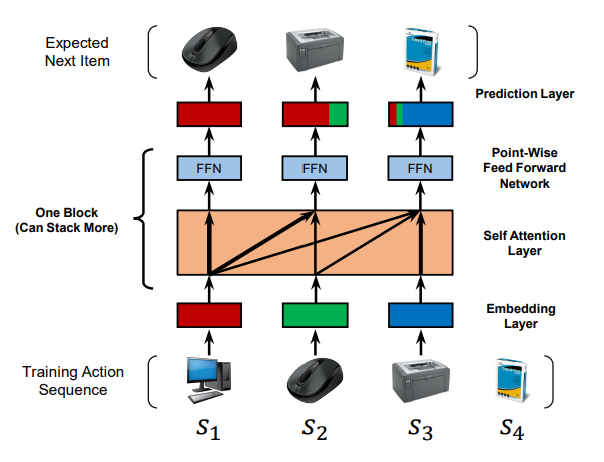

This is a class of sequential recommendation that uses Transformer for encoding the users preference represented in terms of a sequence of items purchased/viewed before. Instead of using CNN (Caser) or RNN (GRU4Rec/SLI-Rec) the approach relies on Transformer based encoder that generates a new representation of the item sequence. This notebook provides an example of necessary steps to train and test a SASRec model. 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
import logging
import papermill as pm
import scrapbook as sb
from tempfile import TemporaryDirectory
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED
from recommenders.models.deeprec.deeprec_utils import (
    prepare_hparams
)
from recommenders.datasets.amazon_reviews import download_and_extract, data_preprocessing
from recommenders.datasets.download_utils import maybe_download

# Transformer Based Models
from recommenders.models.sasrec.model import SASREC
from recommenders.models.sasrec.model_ssept import SSEPT

# Sampler for sequential prediction
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import (data_partition, train)

from recommenders.models.deeprec.io.sequential_iterator import SequentialIterator
#from recommenders.models.deeprec.io.nextitnet_iterator import NextItNetIterator

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

In [ ]:
import os

# disable GPU (for testing)
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
# sys.path.insert(0, "/recsys_data/RecSys/recommenders-tf2/myfork/recommenders/recommenders/models/sasrec")

# from sampler import WarpSampler
# from model import SASREC
# from model_ssept import SSEPT
# from util import *

In [ ]:
# this is a placeholder for all the model parameters
yaml_file = '../../recommenders/models/sasrec/config/sas_rec.yaml'

### Input Parameters

In [ ]:
num_epochs = 5
batch_size = 128
RANDOM_SEED = 100  # Set None for non-deterministic result

data_path = os.path.join("..", "..", "tests", "resources", "deeprec", "slirec")

In [ ]:
data_dir = "/recsys_data/RecSys/SASRec-tf2/data/"

# Amazon Electronics Data (already converted into integer user-ids and item-ids)
dataset = "ae"

lr = 0.001          # learning rate
maxlen = 50         # maximum sequence length for each user
num_blocks = 2      # number of transformer blocks
hidden_units = 100  # number of units in the attention calculation
num_heads = 1       # number of attention heads
dropout_rate = 0.1  # dropout rate
l2_emb = 0.0        # L2 regularization coefficient
num_neg_test = 100  # number of negative examples per positive example

Inputs to the model are 

* user's item history as input to the transformer (with item embedding)
* user's item history shifted as target to the transformer (positive examples)
* a sample of items that are not equal to the positive examples (negative examples)

## Dataset Format 

- The input files should have the following format:
    - each row has user-id and item-id converted into integers (starting from 1)
    - the rows are sorted by user-id and time of interaction
    - for every user the last item is used for testing and the last but one is used for validation
    - for example if user-30450 has interacted with the following items: [26659, 5265, 13312, 11068, 67096] then train input is [0, 0, ..., 0, 26659, 5265] and train positives are [0, 0, ..., 0, 5265, 13312]

In [ ]:
inp_file = os.path.join(data_dir, dataset + ".txt")
print(inp_file)

dataset = data_partition(inp_file)
[user_train, user_valid, user_test, usernum, itemnum] = dataset
num_steps = int(len(user_train) / batch_size)
cc = 0.0
for u in user_train:
    cc += len(user_train[u])
print('%g Users and %g items' % (usernum, itemnum))
print('average sequence length: %.2f' % (cc / len(user_train)))

### Model Creation

Model parameters are 
    - number of items
    - maximum sequence length of the user interaction history
    - number of Transformer blocks
    - embedding dimension for item embedding
    - dimension of the attention
    - number of attention heads
    - dropout rate
    - dimension of the convolution layers, list
    - L_2-regularization coefficient

In [ ]:
model = SASREC(item_num=itemnum,
               seq_max_len=maxlen,
               num_blocks=num_blocks,
               embedding_dim=hidden_units,
               attention_dim=hidden_units,
               attention_num_heads=num_heads,
               dropout_rate=dropout_rate,
            #    conv_dims = kwargs.get("conv_dims", [100, 100])
               l2_reg=l2_emb,
               num_neg_test=num_neg_test
)

### Sampler

    - the sampler creates negative samples from the training data for each batch
    - this is done by looking at the original user interaction history and creating items that are not present at all
    - the sampler generates a sequence of negative items of the same length as the original history

In [ ]:
sampler = WarpSampler(user_train, usernum, itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=3)

### Model Training

    - the loss function is defined over all the negative and positive logits
    - a mask has to be applied to indicate the non-zero items present in the output
    - we also add the regularization loss here
    
    - having a train-step signature function can speed up the training process

In [ ]:
t_test = train(model, dataset, sampler, num_epochs=10, maxlen=maxlen, num_neg_test=num_neg_test, batch_size=batch_size, lr=lr)

In [ ]:
res_syn = {"ndcg@10": t_test[0], "Hit@10": t_test[1]}
print(res_syn)

In [ ]:
# Record results with papermill for tests - ignore this cell
# sb.glue("res_syn", res_syn)

sb.glue("ndcg@10", t_test[0])
sb.glue("Hit@10", t_test[1])